In [21]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

In [2]:
file_path = 'Data assignment 1/Feature data.csv'
data = pd.read_csv(file_path)

### Feature scaling

In this step,we used Principal Component Analysis (PCA) to select and reduce the dimensionality of the features.

In [3]:
scaler_standard = StandardScaler()
scaler_minmax = MinMaxScaler()

### 1. Standard Scaling for wind speed and temperature
data['Mean wind speed'] = scaler_standard.fit_transform(data[['Mean wind speed']])
data['Maximum temperature'] = scaler_standard.fit_transform(data[['Maximum temperature']])

### 2. Wind Direction (convert to sin and cos components)
data['Wind direction sin'] = np.sin(np.deg2rad(data['Mean wind direction']))
data['Wind direction cos'] = np.cos(np.deg2rad(data['Mean wind direction']))

### 3. Normalize Power Production 
nominal_capacity = 30000 # production capacity is 30 MW, unit of power production is kW so nominal capacity is 30000
data['AKI Kalby Active Power'] = data['AKI Kalby Active Power'] / nominal_capacity

# Dropping the original wind direction after transformation
data = data.drop('Mean wind direction', axis=1)

In [4]:
# set target and features
target_column = 'AKI Kalby Active Power'
features = data.drop(columns=[target_column])

In [22]:
# # Impute missing values using mean for numerical columns
# imputer = SimpleImputer(strategy='mean')
# features_imputed = imputer.fit_transform(features)
# 
# # Check for any remaining NaNs after imputation
# features_imputed_df = pd.DataFrame(features_imputed, columns=features.columns)
# print(f"Number of remaining NaNs: {features_imputed_df.isna().sum().sum()}")
# 
# # Drop any rows with NaN values (if any persist after imputation)
# features_imputed_df.dropna(inplace=True)

Number of remaining NaNs: 0


In [23]:
# # standardize the features
# scaler = StandardScaler()
# features_scaled = scaler.fit_transform(features_imputed_df)

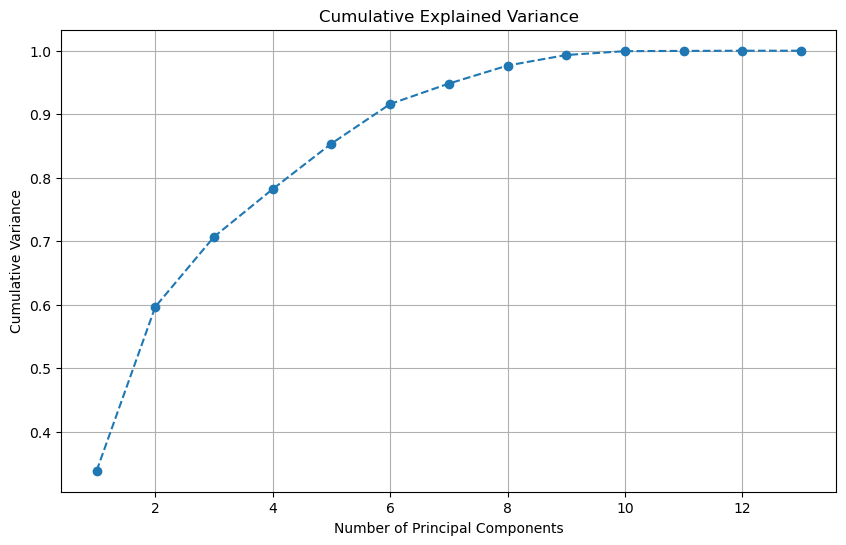

In [24]:
# # apply PCA and plotting
# pca = PCA()
# features_pca = pca.fit_transform(features_scaled)
# explained_variance = pca.explained_variance_ratio_
# cumulative_variance = explained_variance.cumsum()
# 
# plt.figure(figsize=(10, 6))
# plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
# plt.title('Cumulative Explained Variance')
# plt.xlabel('Number of Principal Components')
# plt.ylabel('Cumulative Variance')
# plt.grid()
# plt.show()

 A subset of the original features was selected based on their contribution to the variance in the data. Given the output above, we selected **8** principal components, which capture **over 95%** of the variance in the dataset.

In [25]:
# # determine number and reduce dimension
# n_components = next(i for i, total_var in enumerate(cumulative_variance) if total_var >= 0.95) + 1 # 95% explained
# 
# pca = PCA(n_components=n_components)
# features_reduced = pca.fit_transform(features_scaled)

In [26]:
# # convert to a dataFrame
# features_pca_df = pd.DataFrame(features_reduced, columns=[f'PC{i+1}' for i in range(n_components)])
# features_pca_df[target_column] = data.loc[features_imputed_df.index, target_column].values

In [27]:
# # Get the contribution of each principal component to the original variable
# n_components = features_reduced.shape[1]  
# pca_components_df = pd.DataFrame(pca.components_[:n_components], columns=features_imputed_df.columns)
# 
# # Find the variable that contributes most to each principal component
# top_features_per_component = []
# for i in range(n_components):
#     # Get the variable index with the largest absolute value for each principal component
#     top_feature_index = np.argmax(np.abs(pca_components_df.iloc[i]))
#     top_feature_name = features_imputed_df.columns[top_feature_index]
#     top_features_per_component.append(top_feature_name)
# 
# # Output the selected feature variable name
# print("Name of the feature variable selected by PCA:")
# print(top_features_per_component)


Name of the feature variable selected by PCA:
['AKI Sose Current', 'Mean temperature', 'Mean humidity', 'Mean wind direction', 'Accumulated percipitation', 'AKI Sose Voltage', 'Mean wind speed', 'Mean intensity global radiation']


The original dataset includes actual weather data and historical windpark data. We combined these features into new composite features via PCA. Here we can see the types of the features we selected.

In [28]:
# features_pca_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,Total Wind Production Active Power
0,0.717417,-0.929824,0.964620,-0.579602,0.041593,-0.342002,1.023634,0.196428,3520.388037
1,0.303475,-1.139711,0.946897,-0.474086,-0.075209,-0.346806,0.612685,0.331619,2820.539979
2,1.122774,-0.889858,0.959248,-0.547966,-0.037137,-0.405196,0.595024,0.331005,3302.279146
3,0.170439,-1.085386,1.007671,-0.662887,-0.038052,0.261460,0.879299,0.191318,2035.389565
4,-0.458317,-1.514081,0.838381,-0.731493,0.343030,-0.542508,0.723237,0.300194,863.109576
...,...,...,...,...,...,...,...,...,...
8755,4.316115,1.104633,0.805460,-0.157699,-0.396864,-1.202099,-0.169008,0.089651,4396.705882
8756,4.079903,0.965660,0.893787,-0.197413,-0.366270,-1.429302,-0.570861,0.274991,4555.911707
8757,2.788152,0.354614,1.021897,0.316802,0.279980,-1.563630,0.206157,0.142289,3928.631381
8758,2.014131,0.111007,1.400603,0.463976,0.517952,-0.748807,0.646494,0.073853,3481.610785


**Dataset Split**: 
  - The notebook splits the dataset into training and testing sets using an 80-20 split. This means 80% of the data is used for training the model, while the remaining 20% is used for testing.
  - This split was done using the `train_test_split` function from `scikit-learn`.

**Contents of the Training and Testing Datasets**:
  - **Training Dataset**: Contains the selected principal components as input features (`X_train`) and the target variable (`y_train`), which is the wind farm's power production.
  - **Testing Dataset**: Contains the same input features (`X_test`) and target variable (`y_test`) as the training dataset but is reserved for evaluating the model's performance.

In [5]:
data.set_index('datetime', inplace=True)


In [30]:
data

,AKI Kalby Active Power,Maximum temperature,Mean wind speed,Wind direction sin,Wind direction cos
datetime,,,,,
2022-01-01 00:00:00,-16.221342,-0.427942,0.796147,-0.998630,-5.233596e-02
2022-01-01 01:00:00,-13.486144,-0.427942,0.325241,-0.956305,-2.923717e-01
2022-01-01 02:00:00,-32.546168,-0.473365,0.687476,-0.994522,-1.045285e-01
2022-01-01 03:00:00,-14.911769,-0.488506,0.433912,-1.000000,-1.836970e-16
2022-01-01 04:00:00,-4.761472,-0.443083,0.252794,-0.951057,3.090170e-01
...,...,...,...,...,...
2022-12-31 19:00:00,-64.372044,0.041428,1.846631,-0.656059,-7.547096e-01
2022-12-31 20:00:00,-58.672623,0.071710,1.375724,-0.731354,-6.819984e-01
2022-12-31 21:00:00,-45.096287,0.071710,1.411948,-0.681998,-7.313537e-01


In [6]:
# split the data
X = data.drop(columns=[target_column])
y = data[target_column]

split_data= TimeSeriesSplit(n_splits=3, test_size=int(0.2*len(data)))
for train_index, test_index in split_data.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
print("TRAIN indices:", train_index, "TEST indices:", test_index)
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

TRAIN indices: [   0    1    2 ... 7005 7006 7007] TEST indices: [7008 7009 7010 ... 8757 8758 8759]
X_train shape: (7008, 4)
X_test shape: (1752, 4)
y_train shape: (7008,)
y_test shape: (1752,)


### Step 3 Linear regression

In [11]:
# Step 3.1 Please show that these two methods end up with the same solution.
# start with 100 datapoints  
X_sample, X_test_sample, y_sample, y_test_sample = train_test_split(data[:100], data[target_column][:100], test_size=0.2, random_state=42)

In [12]:
# gradient descent
def gradient_descent(X, y, learning_rate=0.01, epochs=100000):
    m, n = X.shape
    theta = np.zeros(n)
    for _ in range(epochs):
        y_pred = X @ theta
        gradients = (1/m) * X.T @ (y_pred - y)
        theta -= learning_rate * gradients
    return theta

# Adding a column of ones to X_sample for the bias term
X_sample_with_bias = np.c_[np.ones(X_sample.shape[0]), X_sample]
X_test_sample_with_bias = np.c_[np.ones(X_test_sample.shape[0]), X_test_sample]

theta_gd = gradient_descent(X_sample_with_bias, y_sample)
y_pred_gd = X_test_sample_with_bias @ theta_gd
print(theta_gd)

C:\Users\cmenn\AppData\Local\Temp\ipykernel_3276\2706233018.py:6: RuntimeWarning: invalid value encountered in matmul
  y_pred = X @ theta


[nan nan nan nan nan nan]


In [13]:
# closed-Form solution
theta_closed_form = np.linalg.inv(X_sample_with_bias.T @ X_sample_with_bias) @ X_sample_with_bias.T @ y_sample
y_pred_closed_form = X_test_sample_with_bias @ theta_closed_form
print(theta_closed_form)

[3.80563636e-14 1.00000000e+00 1.22346577e-13 3.09752224e-14
 4.22994972e-14 1.45439216e-14]


In [14]:
print("Gradient Descent MSE:", mean_squared_error(y_test_sample, y_pred_gd))
print("Closed-Form MSE:", mean_squared_error(y_test_sample, y_pred_closed_form))

ValueError: Input contains NaN.

In [34]:
# Step 3.2 Please increase the number of samples to improve the accuracy of prediction and only use the closed form solution
X_large_sample, X_large_test_sample, y_large_sample, y_large_test_sample = train_test_split(features_reduced, data[target_column], test_size=0.2, random_state=42)

# Adding a column of ones for the bias term in the large sample
X_large_sample_with_bias = np.c_[np.ones(X_large_sample.shape[0]), X_large_sample]
X_large_test_sample_with_bias = np.c_[np.ones(X_large_test_sample.shape[0]), X_large_test_sample]

# upgrade the normal equation
theta_large_sample = np.linalg.inv(X_large_sample_with_bias.T @ X_large_sample_with_bias) @ X_large_sample_with_bias.T @ y_large_sample
theta_large_sample_rounded = np.round(theta_large_sample, 2)

print(f"Step 3.2: Closed-form solution training complete on the larger sample.")
print(f"Coefficients: {theta_large_sample_rounded}")

Step 3.2: Closed-form solution training complete on the larger sample.
Coefficients: [1866.75  584.16  395.71  101.27   -8.56 -124.97  255.91    2.27 -171.51]


Given this output, we can get the optimal model: 

$$
y = 1866.75 + 584.16x_1 + 395.71x_2 + 101.27x_3 - 8.56x_4 - 124.97x_5 + 255.91x_6 + 2.27x_7 - 171.51x_8
$$

Here: 
- $ y $ is the target
- $ x_1, x_2, \dots, x_8 $ are selected features

In [35]:
# Step 3.3 Verify your model using the testing dataset and appropriate evaluation metrics
y_large_pred_closed_form = X_large_test_sample_with_bias @ theta_large_sample

mse = mean_squared_error(y_large_test_sample, y_large_pred_closed_form)
mae = mean_absolute_error(y_large_test_sample, y_large_pred_closed_form)
r2 = r2_score(y_large_test_sample, y_large_pred_closed_form)
rmse = np.sqrt(mse)

print(f"Step 3.3: Model evaluation on the testing dataset:")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared: {r2:.4f}")

Step 3.3: Model evaluation on the testing dataset:
Root Mean Squared Error (RMSE): 1293.0691
Mean Squared Error (MSE): 1672027.6484
Mean Absolute Error (MAE): 902.1377
R-squared: 0.5935


### Step 4 Non-linear Regression

In Step 1's formulation, if the price $\lambda$ is treated as a constant and the actual value p is known, the entire formula simplifies into a function dependent on the predicted value $\hat{p}_t$. This implies that the problem can be reframed as an optimization task concerning the prediction of $\hat{p}_t$. Given this perspective, extending the linear regression model from Step 3 by incorporating nonlinear features to predict $\hat{p}_t$ effectively transforms the problem into a nonlinear regression for Step 1's objective. Therefore, performing nonlinear regression on the prediction model of $\hat{p}_t$ inherently satisfies the requirements of the nonlinear extension outlined in Step 4.

In [36]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

In [37]:
# Step 4.1 Add polynomial features (squared and cubic terms)
poly = PolynomialFeatures(degree=3, include_bias=False) 
X_poly = poly.fit_transform(features_reduced)

# convert to DataFrame
X_poly_df = pd.DataFrame(X_poly, columns=poly.get_feature_names_out(features_pca_df.columns[:-1]))

# split the polynomial feature data
X_train_poly, X_test_poly, y_train_poly, y_test_poly = train_test_split(X_poly_df, y, test_size=0.2, random_state=42)

# fit linear regression model on the polynomial features
linear_model_poly = LinearRegression()
linear_model_poly.fit(X_train_poly, y_train_poly)

# predict on the testing data
y_pred_poly = linear_model_poly.predict(X_test_poly)

In [38]:
# evaluate the performance
mse_poly = mean_squared_error(y_test_poly, y_pred_poly)
mae_poly = mean_absolute_error(y_test_poly, y_pred_poly)
r2_poly = r2_score(y_test_poly, y_pred_poly)
rmse_poly = np.sqrt(mse_poly)

print(f"Nonlinear model evaluation on the testing dataset:")
print(f"Root Mean Squared Error (RMSE): {rmse_poly:.4f}")
print(f"Mean Squared Error (MSE): {mse_poly:.4f}")
print(f"Mean Absolute Error (MAE): {mae_poly:.4f}")
print(f"R-squared: {r2_poly:.4f}")

Nonlinear Model Evaluation on the Testing Dataset:
Root Mean Squared Error (RMSE): 923.4014
Mean Squared Error (MSE): 852670.1829
Mean Absolute Error (MAE): 600.8771
R-squared: 0.7927


For step 4.2, the method of locally weighted least squares will be used, as tought in the lecture. Different kernels will be compared and the best one will be chosen based on evaluating the performance on the test data.

In [ ]:
def gaussian(t):
    return np.exp(-0.5 * t**2) / np.sqrt(2 * np.pi)

def epanechnikov(t):
    res = np.zeros_like(t)
    res[np.abs(t) <= 1] = 0.75 * (1 - t[np.abs(t) <= 1]**2)
    return res

def tricube(t):
    res = np.zeros_like(t)
    res[np.abs(t) <= 1] = (70 / 81) * (1 - np.abs(t[np.abs(t) <= 1])**3)**3
    return res

def uniform(t, p=0.2):
    return np.zeros_like(t) + p

def triangle(t):
    res = np.zeros_like(t)
    res[np.abs(t) <= 1] = 1 - np.abs(t[np.abs(t) <= 1])
    return res

In [18]:
def wls_gaussian(training_data):
    %time 
    radius = 0.2
    
    y_pred_wls = np.zeros(len(training_data))
    for i in range(len(training_data)):
        W = np.diagflat(gaussian(np.linalg.norm(X - training_data[i], axis=1) / radius))
        theta = np.linalg.inv(X.T @ W @ X) @ X.T @ W @ y.reshape(-1, 1)
        y_pred_wls[i] = training_data[i] @ theta
    return y_pred_wls

def wls_epanechnikov(training_data):
    %time 
    radius = 0.2
    
    y_pred_wls = np.zeros(len(training_data))
    for i in range(len(training_data)):
        W = np.diagflat(epanechnikov(np.linalg.norm(X - training_data[i], axis=1) / radius))
        theta = np.linalg.inv(X.T @ W @ X) @ X.T @ W @ y.reshape(-1, 1)
        y_pred_wls[i] = training_data[i] @ theta
    return y_pred_wls

def wls_tricube(training_data):
    %time 
    radius = 0.2
    
    y_pred_wls = np.zeros(len(training_data))
    for i in range(len(training_data)):
        W = np.diagflat(tricube(np.linalg.norm(X - training_data[i], axis=1) / radius))
        theta = np.linalg.inv(X.T @ W @ X) @ X.T @ W @ y.reshape(-1, 1)
        y_pred_wls[i] = training_data[i] @ theta
    return y_pred_wls

def wls_uniform(training_data):
    %time 
    radius = 0.2
    
    y_pred_wls = np.zeros(len(training_data))
    for i in range(len(training_data)):
        W = np.diagflat(uniform(np.linalg.norm(X - training_data[i], axis=1) / radius))
        theta = np.linalg.inv(X.T @ W @ X) @ X.T @ W @ y.reshape(-1, 1)
        y_pred_wls[i] = training_data[i] @ theta
    return y_pred_wls

def wls_triangle(training_data):
    %time 
    radius = 0.2
    
    y_pred_wls = np.zeros(len(training_data))
    for i in range(len(training_data)):
        W = np.diagflat(triangle(np.linalg.norm(X - training_data[i], axis=1) / radius))
        theta = np.linalg.inv(X.T @ W @ X) @ X.T @ W @ y.reshape(-1, 1)
        y_pred_wls[i] = training_data[i] @ theta
    return y_pred_wls

In [ ]:
# Step 4.2 Locally weighted least squared
y_pred_wls_gaussian = wls_gaussian(X_large_sample)
y_pred_wls_epanechnikov = wls_epanechnikov(X_large_sample)
y_pred_wls_tricube = wls_tricube(X_large_sample)
y_pred_wls_uniform = wls_uniform(X_large_sample)
y_pred_wls_triangle = wls_triangle(X_large_sample)

In [ ]:
mse_wls_g = mean_squared_error(y_large_test_sample, y_pred_wls_gaussian)
mae_wls_g = mean_absolute_error(y_large_test_sample, y_pred_wls_gaussian)
r2_wls_g = r2_score(y_large_test_sample, y_pred_wls_gaussian)
rmse_wls_g = np.sqrt(mse_wls_g)

print(f"Weighted Least Squares model evaluation on the testing dataset with Gaussian kernel:")
print(f"Root Mean Squared Error (RMSE): {rmse_wls_g:.4f}")
print(f"Mean Squared Error (MSE): {mse_wls_g:.4f}")
print(f"Mean Absolute Error (MAE): {mae_wls_g:.4f}")
print(f"R-squared: {r2_wls_g:.4f}")

In [19]:
mse_wls_e = mean_squared_error(y_large_test_sample,y_pred_wls_epanechnikov)
mae_wls_e = mean_absolute_error(y_large_test_sample, y_pred_wls_epanechnikov)
r2_wls_e = r2_score(y_large_test_sample, y_pred_wls_epanechnikov)
rmse_wls_e = np.sqrt(mse_wls_e)

print(f"Weighted Least Squares model evaluation on the testing dataset with Epanechnikov kernel:")
print(f"Root Mean Squared Error (RMSE): {rmse_wls_e:.4f}")
print(f"Mean Squared Error (MSE): {mse_wls_e:.4f}")
print(f"Mean Absolute Error (MAE): {mae_wls_e:.4f}")
print(f"R-squared: {r2_wls_e:.4f}")

NameError: name 'y_large_test_sample' is not defined

In [ ]:
mse_wls_tricube = mean_squared_error(y_large_test_sample, y_pred_wls_tricube)
mae_wls_tricube = mean_absolute_error(y_large_test_sample, y_pred_wls_tricube)
r2_wls_tricube = r2_score(y_large_test_sample, y_pred_wls_tricube)
rmse_wls_tricube = np.sqrt(mse_wls_tricube)

print(f"Weighted Least Squares model evaluation on the testing dataset with tricube kernel:")
print(f"Root Mean Squared Error (RMSE): {rmse_wls_tricube:.4f}")
print(f"Mean Squared Error (MSE): {mse_wls_tricube:.4f}")
print(f"Mean Absolute Error (MAE): {mae_wls_tricube:.4f}")
print(f"R-squared: {r2_wls_tricube:.4f}")

In [ ]:
mse_wls_uni = mean_squared_error(y_large_test_sample, y_pred_wls_uniform)
mae_wls_uni = mean_absolute_error(y_large_test_sample, y_pred_wls_uniform)
r2_wls_uni = r2_score(y_large_test_sample, y_pred_wls_uniform)
rmse_wls_uni = np.sqrt(mse_wls_uni)

print(f"Weighted Least Squares model evaluation on the testing dataset with uniform kernel:")
print(f"Root Mean Squared Error (RMSE): {rmse_wls_uni:.4f}")
print(f"Mean Squared Error (MSE): {mse_wls_uni:.4f}")
print(f"Mean Absolute Error (MAE): {mae_wls_uni:.4f}")
print(f"R-squared: {r2_wls_uni:.4f}")

In [ ]:
mse_wls_tri = mean_squared_error(y_large_test_sample, y_pred_wls_triangle)
mae_wls_tri = mean_absolute_error(y_large_test_sample, y_pred_wls_triangle)
r2_wls_tri = r2_score(y_large_test_sample, y_pred_wls_triangle)
rmse_wls_tri = np.sqrt(mse_wls_tri)

print(f"Weighted Least Squares model evaluation on the testing dataset with triangle kernel:")
print(f"Root Mean Squared Error (RMSE): {rmse_wls_tri:.4f}")
print(f"Mean Squared Error (MSE): {mse_wls_tri:.4f}")
print(f"Mean Absolute Error (MAE): {mae_wls_tri:.4f}")
print(f"R-squared: {r2_wls_tri:.4f}")